In [1]:
from modeling.data_handling.data_loading import league_data_loader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
train_df = league_data_loader(range(2010, 2015))
val_df = league_data_loader(range(2015, 2016))

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


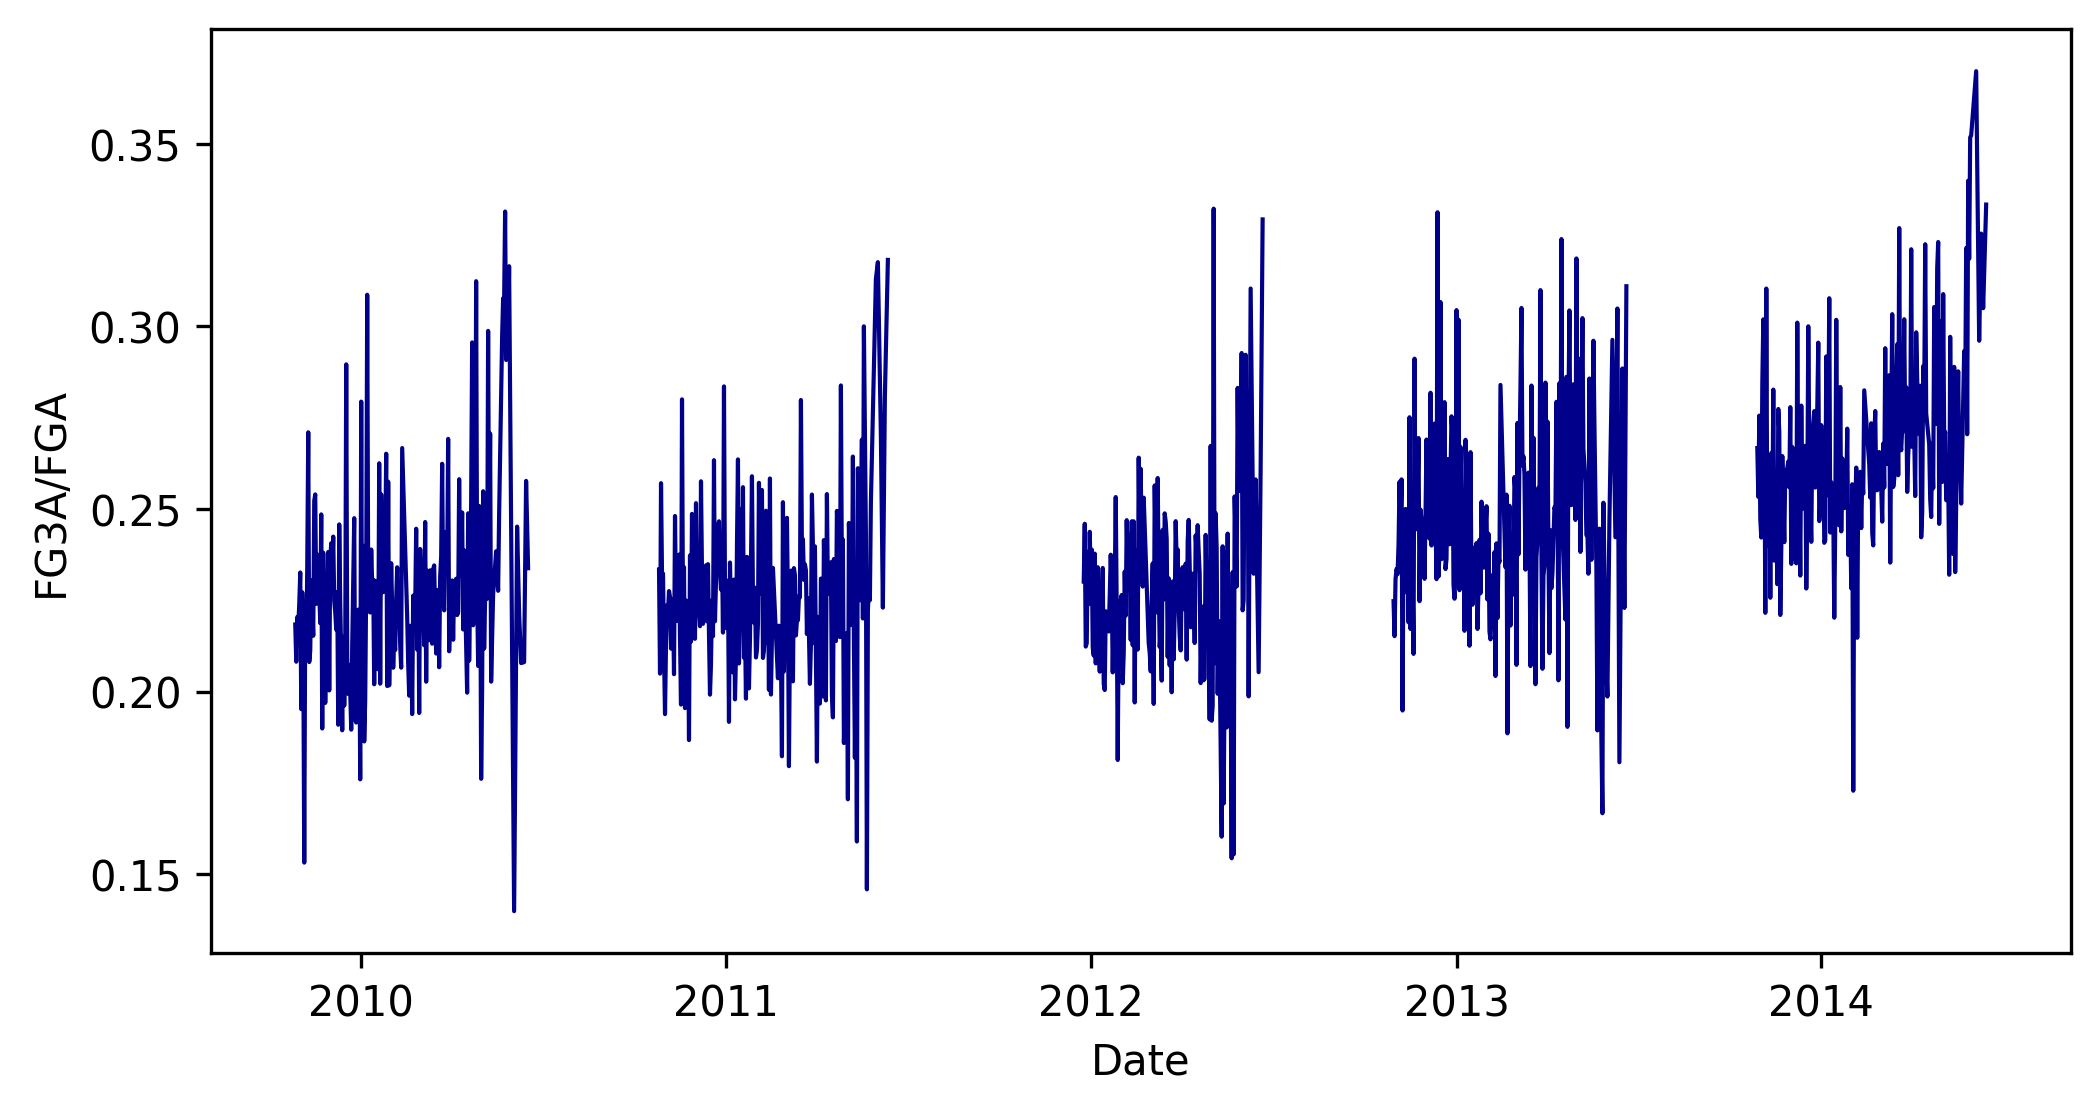

In [3]:
plt.figure(figsize=(8, 4), dpi=300)
for season in sorted(train_df.season.unique()):
    season_df = train_df[train_df.season == season]
    plt.plot(
        season_df.game_date, season_df.league_avg_fg3a_fga,
        color="darkblue", linewidth=1
    )
plt.xlabel("Date")
plt.ylabel("FG3A/FGA")
plt.savefig("plots/training-results.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
df = pd.read_csv("modeling/league_avg_fg3a_fga_predictions.csv")
df_lstm = pd.read_csv("modeling/lstm/lstm_test_predictions.csv")
df_cnn = pd.read_csv("modeling/causal_cnn/cnn_test_predictions.csv")
df_hierarchical = pd.read_csv("modeling/hierarchical/hierarchical_league_data.csv")

In [5]:
def weighted_mse(true, pred, weights):
    return (weights * (true - pred) ** 2).sum() / weights.sum()

weighted_mse(df.league_avg_fg3a_fga, df.league_avg_fg3a_fga.mean(), df_cnn.fga)

0.001372641630738644

In [6]:
h_preds = df_hierarchical.league_predictions
h_preds = h_preds - h_preds.mean() + 2 * val_df.league_avg_fg3a_fga.mean() - train_df.league_avg_fg3a_fga.mean()
print(
    weighted_mse(
        df_hierarchical.league_avg_fg3a_fga, h_preds, df_hierarchical.fga
    )
)
print(
    weighted_mse(
        df_hierarchical.league_avg_fg3a_fga,
        df_hierarchical.league_predictions,
        df_hierarchical.fga
    )
)

0.0017013888734566936
0.0045848108388276765


In [7]:
df_hierarchical = pd.read_csv("modeling/hierarchical/hierarchical_player_data.csv")
df_hierarchical.player_predictions[df_hierarchical.player_predictions < 0] = 0
h_df_ad = df_hierarchical[df_hierarchical.athlete_display_name == "Anthony Davis"]
h_df_bl = df_hierarchical[df_hierarchical.athlete_display_name == "Brook Lopez"]

/var/folders/w9/qq2rt_td0bd_p2q1jrmg_lpw0000gn/T/ipykernel_1263/1688351002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hierarchical.player_predictions[df_hierarchical.player_predictions < 0] = 0


0.0051338785128148745
[[1.         0.51271207]
 [0.51271207 1.        ]]


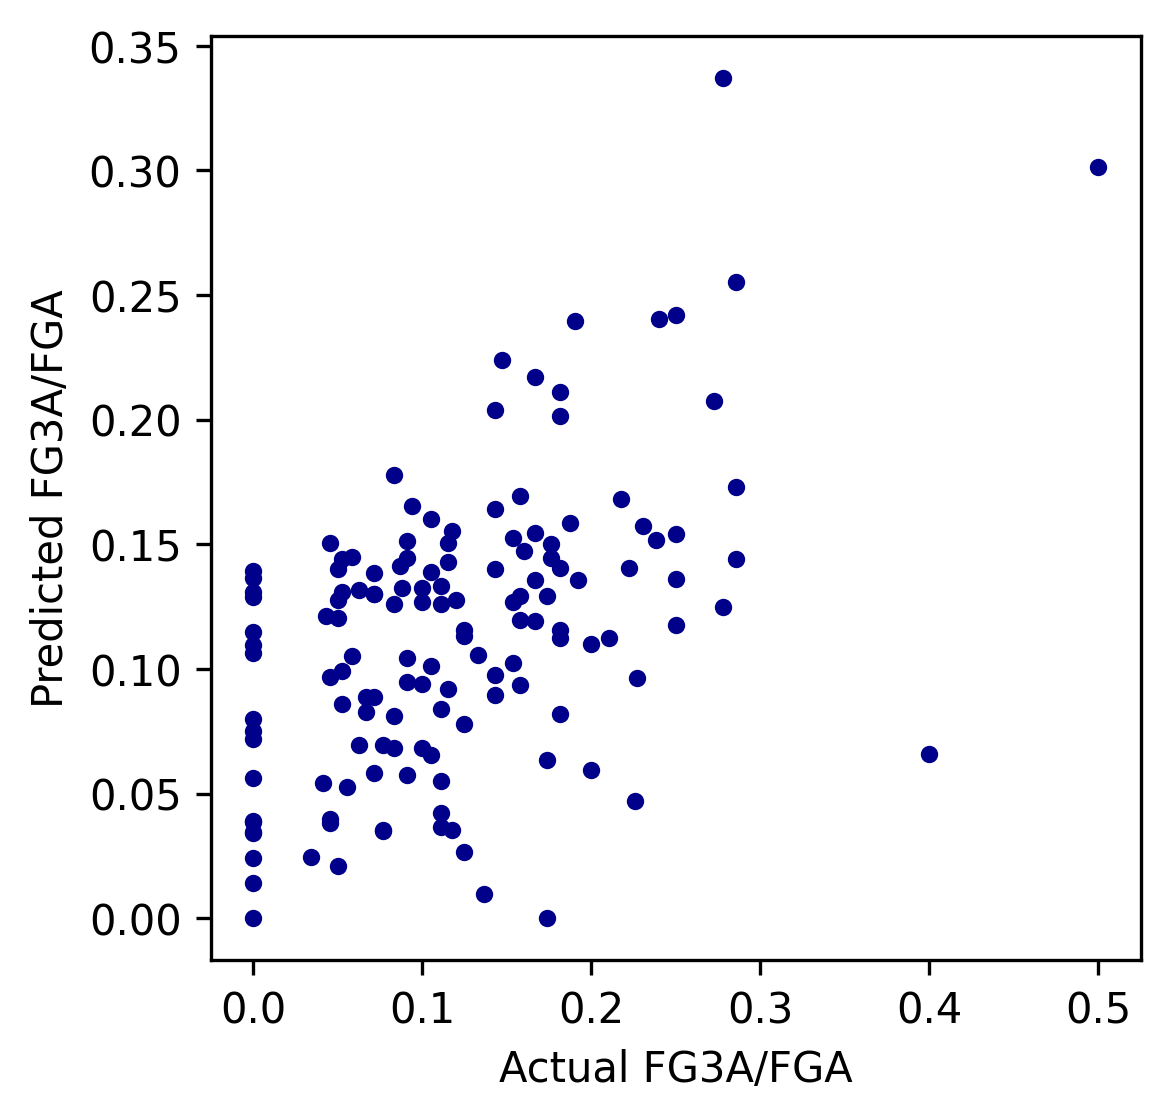

In [8]:
print(weighted_mse(h_df_ad.fg3a_fga, h_df_ad.player_predictions, h_df_ad.fga))
print(np.corrcoef(h_df_ad.fg3a_fga, h_df_ad.player_predictions))
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_ad.fg3a_fga, h_df_ad.player_predictions, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/ad-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/w9/qq2rt_td0bd_p2q1jrmg_lpw0000gn/T/ipykernel_1263/1165863278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_bl.game_date = pd.to_datetime(sub_df_bl.game_date)
/var/folders/w9/qq2rt_td0bd_p2q1jrmg_lpw0000gn/T/ipykernel_1263/1165863278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_bl.game_date = pd.to_datetime(sub_df_bl.game_date)


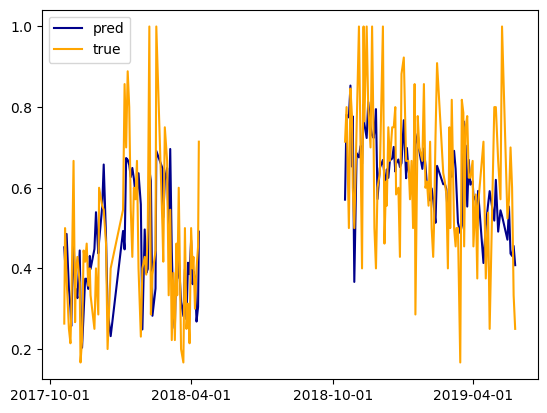

In [9]:
for i, season in enumerate(sorted(h_df_bl.season.unique())):
    sub_df_bl = h_df_bl[h_df_bl.season == season]
    sub_df_bl.game_date = pd.to_datetime(sub_df_bl.game_date)
    if i == 0:
        plt.plot(sub_df_bl.game_date, sub_df_bl.player_predictions, color="darkblue", label="pred")
        plt.plot(sub_df_bl.game_date, sub_df_bl.fg3a_fga, color="orange", label="true")
    else:
        plt.plot(sub_df_bl.game_date, sub_df_bl.player_predictions, color="darkblue")
        plt.plot(sub_df_bl.game_date, sub_df_bl.fg3a_fga, color="orange")

plt.xticks(["2017-10-01", "2018-04-01", "2018-10-01", "2019-04-01"])
plt.legend()
plt.show()

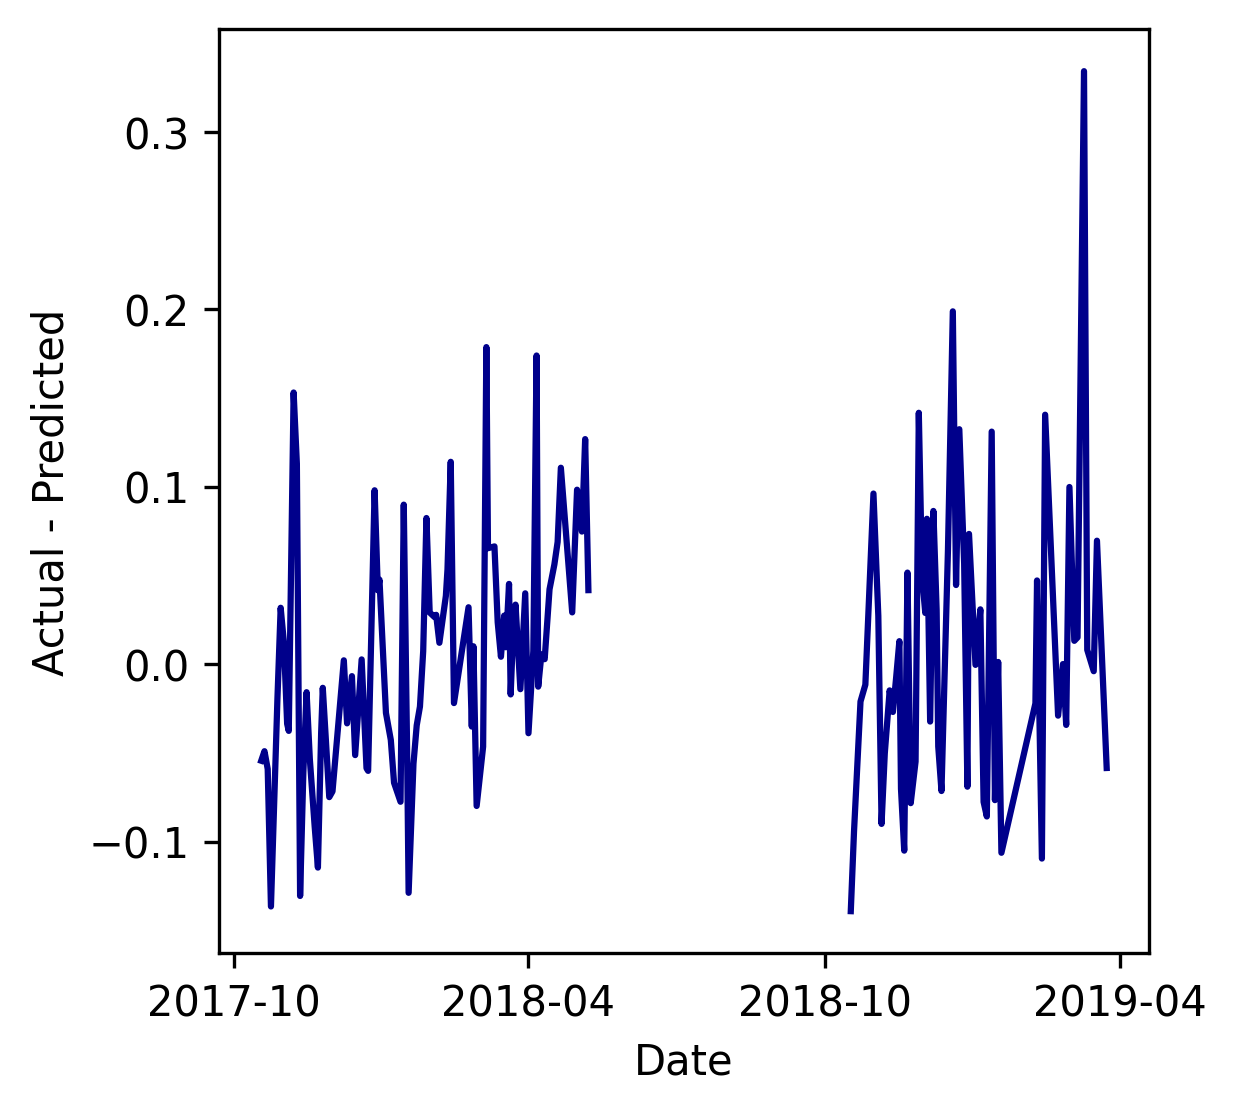

In [10]:
plt.figure(figsize=(4, 4), dpi=300)
dates = pd.to_datetime(h_df_ad.game_date)
true = h_df_ad.fg3a_fga
preds = h_df_ad.player_predictions
plt.plot(
    dates[dates < "2018-08-01"],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2017-10", "2018-04", "2018-10", "2019-04"], ["2017-10", "2018-04", "2018-10", "2019-04"])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/ad-residuals.png", dpi=300, bbox_inches="tight")
plt.show()

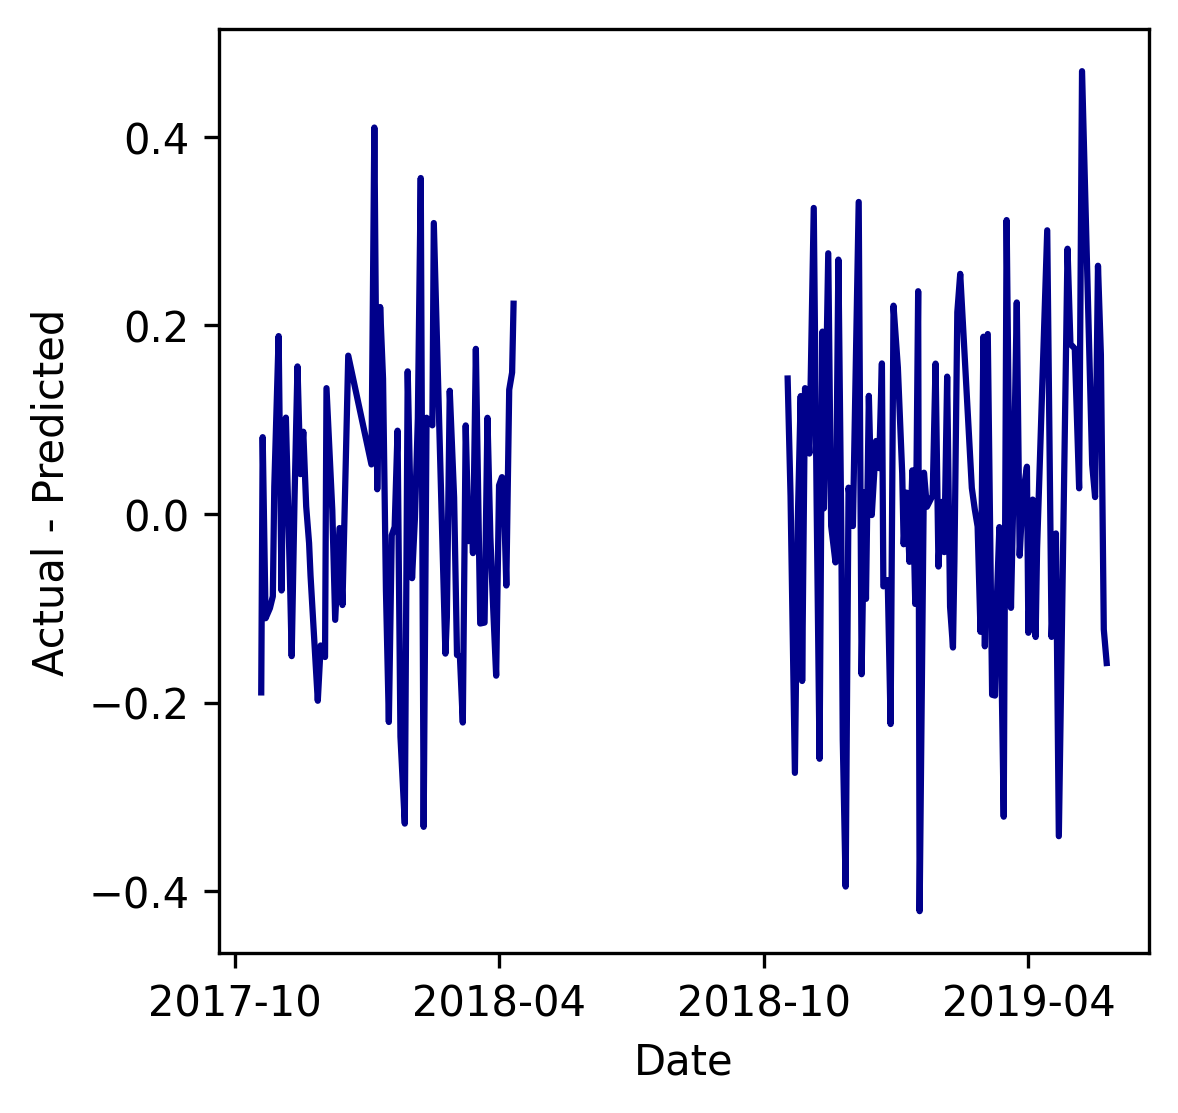

In [11]:
plt.figure(figsize=(4, 4), dpi=300)
dates = pd.to_datetime(h_df_bl.game_date)
true = h_df_bl.fg3a_fga
preds = h_df_bl.player_predictions
plt.plot(
    dates[dates < "2018-08-01"],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2017-10", "2018-04", "2018-10", "2019-04"], ["2017-10", "2018-04", "2018-10", "2019-04"])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/bl-residuals.png", dpi=300, bbox_inches="tight")
plt.show()

0.021989640332913018
[[1.         0.64410965]
 [0.64410965 1.        ]]


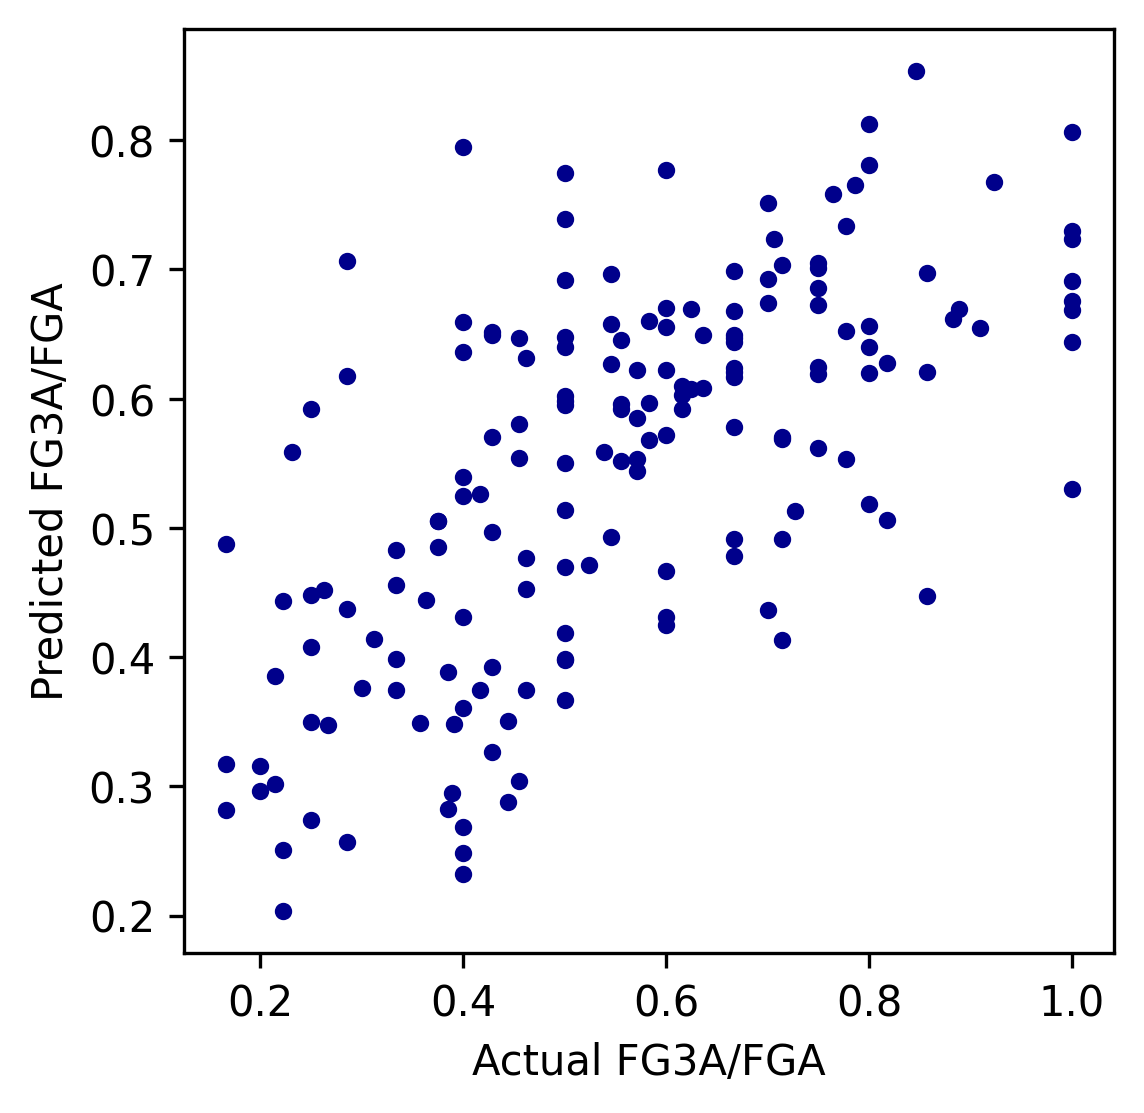

In [12]:
print(weighted_mse(h_df_bl.fg3a_fga, h_df_bl.player_predictions, h_df_bl.fga))
print(np.corrcoef(h_df_bl.fg3a_fga, h_df_bl.player_predictions))
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_bl.fg3a_fga, h_df_bl.player_predictions, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/bl-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
print(mean_squared_error(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga))
print(r2_score(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga))
print(weighted_mse(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga, df_lstm.fga))

0.0009625766473421483
0.4593597363423908
0.0006291562388663707


0.0011774107653244046
0.33742774853083335
[[1.         0.60496675]
 [0.60496675 1.        ]]


0.0007346204565743974

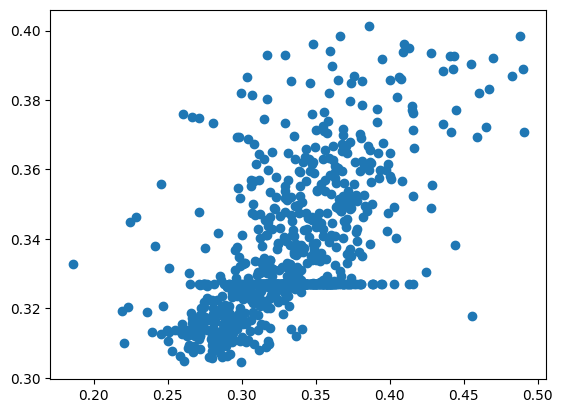

In [14]:
plt.scatter(df_lstm.league_avg_fg3a_fga[4:], df_lstm.Predictions[:-4])
print(mean_squared_error(np.array(df_lstm.league_avg_fg3a_fga.iloc[4:]), np.array(df_lstm.Predictions[:-4])))
print(r2_score(df_lstm.league_avg_fg3a_fga.iloc[4:], df_lstm.Predictions[:-4]))
print(np.corrcoef(df_lstm.league_avg_fg3a_fga.iloc[4:], df_lstm.Predictions[:-4]))
weighted_mse(df_lstm.league_avg_fg3a_fga.iloc[4:],df_lstm.Predictions[:-4], df_lstm.fga.iloc[4:])

0.0012271944240923784
0.30941265656148065
[[1.        0.6557015]
 [0.6557015 1.       ]]
0.000449374091007161


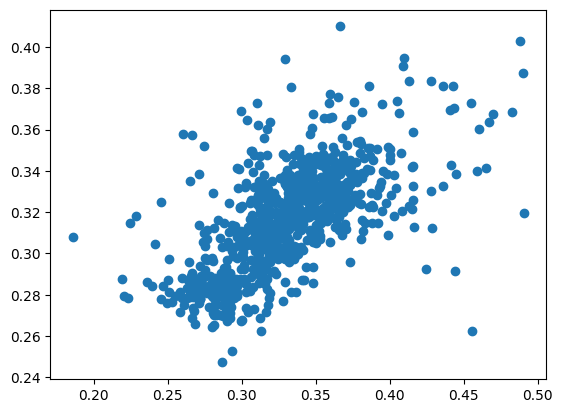

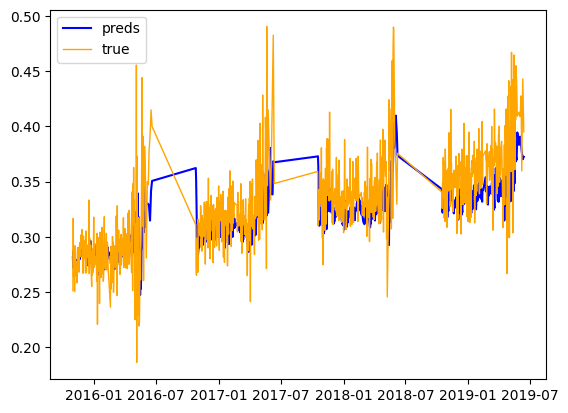

In [15]:
plt.scatter(df_cnn.league_avg_fg3a_fga[4:], df_cnn.Predictions[:-4])
print(mean_squared_error(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(r2_score(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(np.corrcoef(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(weighted_mse(df_cnn.league_avg_fg3a_fga.iloc[4:],
             df_cnn.Predictions[:-4],
              df_cnn.fga.iloc[4:]
            ))
plt.show()
plt.plot(pd.to_datetime(df.game_date.iloc[3:]), df_cnn.Predictions.iloc[:-4], color="blue", label="preds")
plt.plot(pd.to_datetime(df.game_date.iloc[3:]), df.league_avg_fg3a_fga.iloc[3:], color='orange', label="true", linewidth=1)
plt.legend()
plt.show()

In [16]:
preds = df_cnn.Predictions.iloc[:-4].reset_index(drop=True)
dates = pd.to_datetime(df.game_date.iloc[3:].reset_index(drop=True))
true = df_cnn.league_avg_fg3a_fga.iloc[4:].reset_index(drop=True)
weights = df_cnn.fga.iloc[4:].reset_index(drop=True)

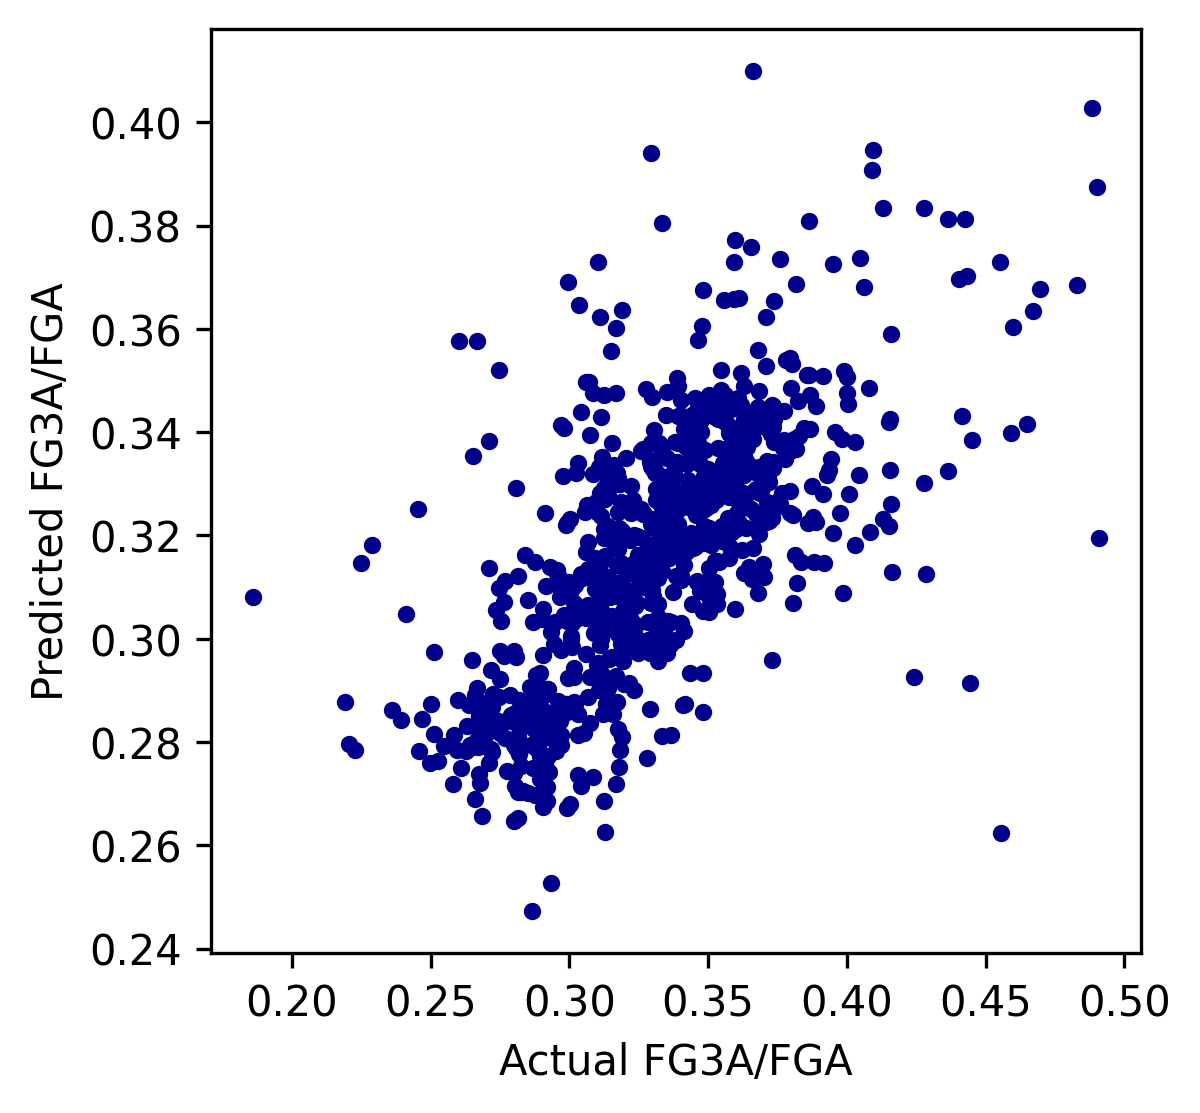

In [17]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(true, preds, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/preds-actual.png", dpi=300, bbox_inches="tight")
plt.show()

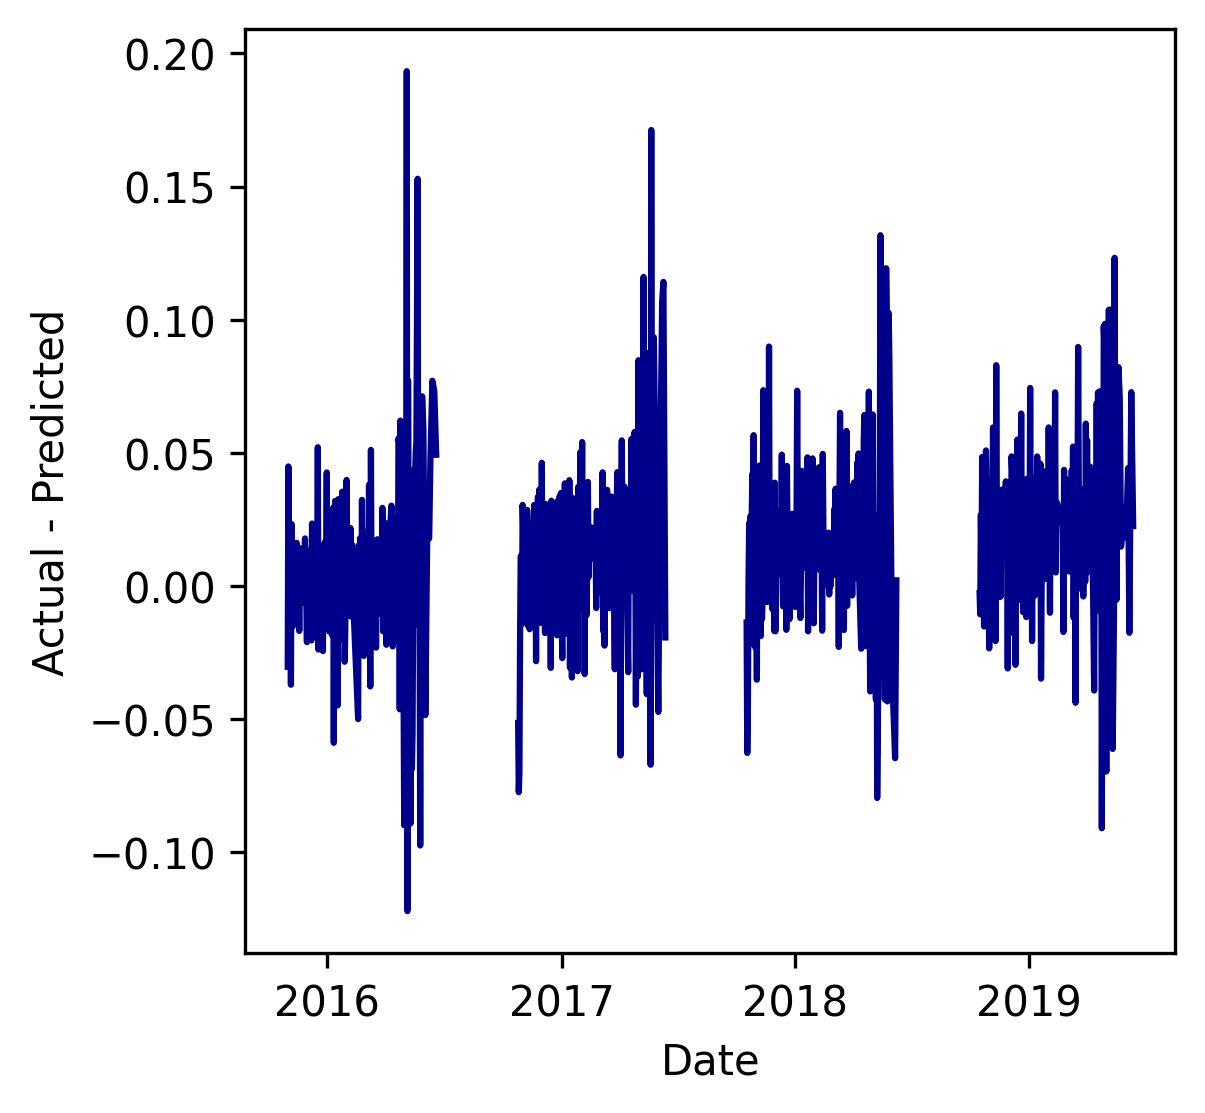

In [18]:
plt.figure(figsize=(4, 4), dpi=300)
plt.plot(dates[dates < "2016-08-01"], (true - preds)[dates < "2016-08-01"], color="darkblue")
plt.plot(
    dates[(dates < "2017-08-01") & (dates >= "2016-08-01")],
    (true - preds)[(dates < "2017-08-01") & (dates >= "2016-08-01")],
    color="darkblue"
)
plt.plot(
    dates[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"], [*range(2016, 2020)])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/residuals.png", dpi=300, bbox_inches="tight")
plt.show()

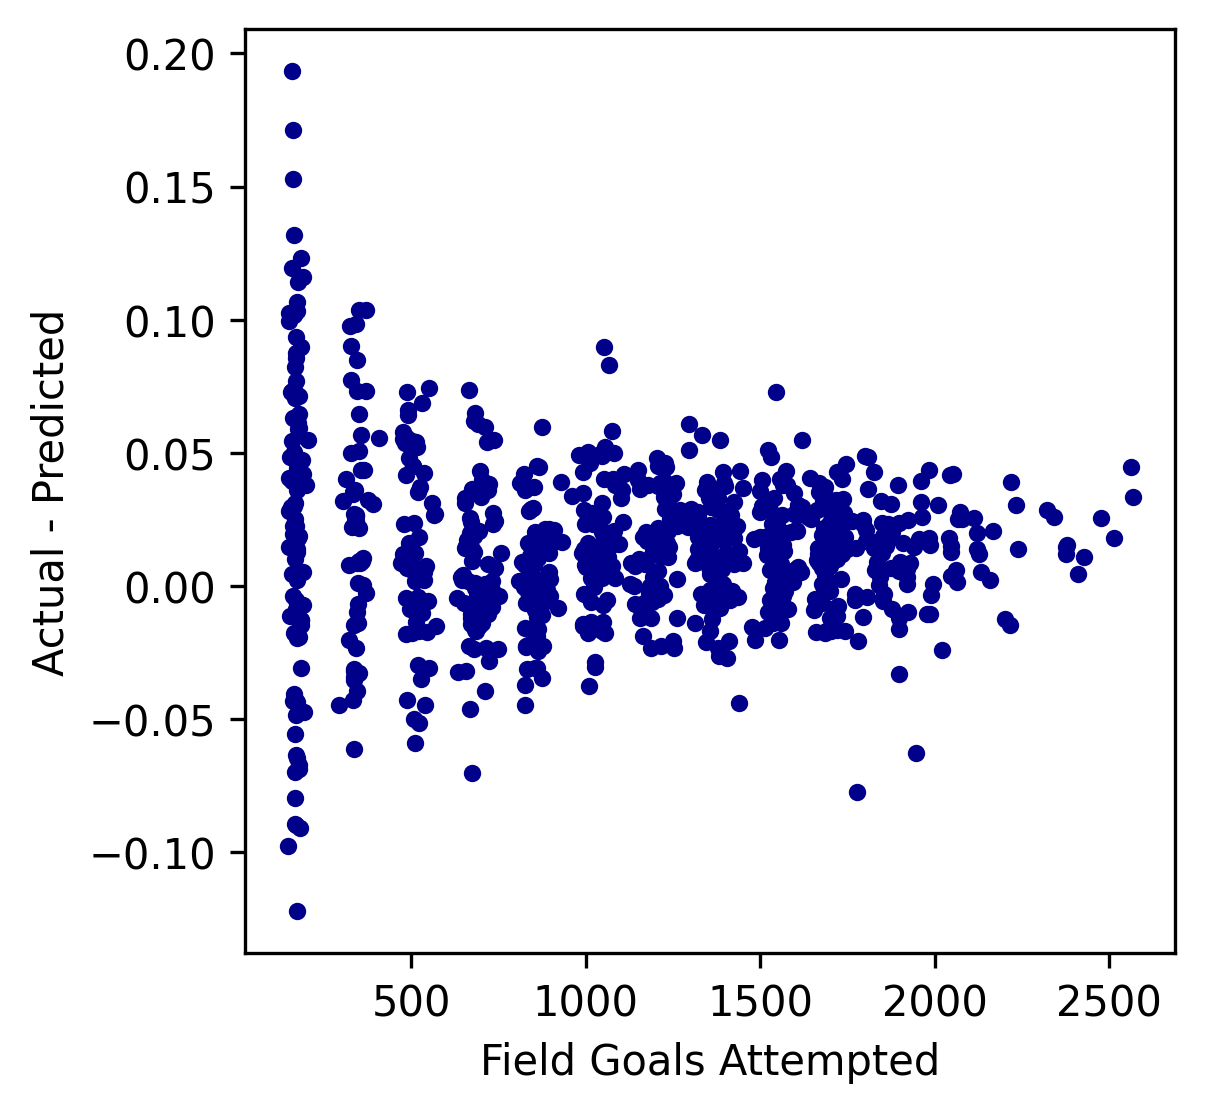

In [19]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(weights, true - preds, s = 10, color="darkblue")
plt.xlabel("Field Goals Attempted")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/residuals-weights.png", dpi=300, bbox_inches="tight")

In [20]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga'])

0.038556145027120854


0.09829409429142177

In [21]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions_CNN.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga']))
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], df_bl.field_goals_attempted))

0.03863449109618111
0.0964618283034453
0.035783703435920425


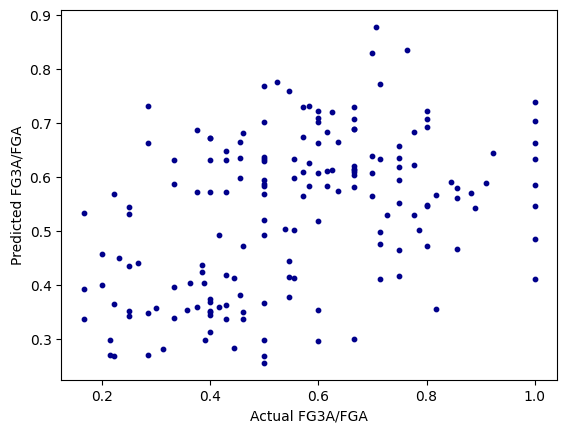

In [22]:
plt.scatter(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/bl-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
np.corrcoef(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'])

array([[1.        , 0.42393001],
       [0.42393001, 1.        ]])

In [24]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions_CNN.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.006920900640702241
0.05718584790370318
0.006211971295548302


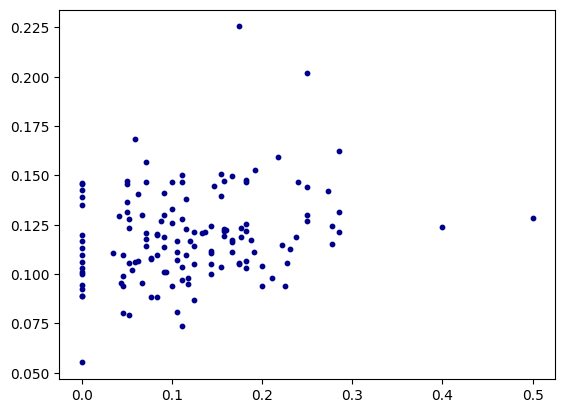

In [25]:
plt.scatter(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], s=10, color="darkblue")

In [26]:
np.corrcoef(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'])

array([[1.        , 0.24120603],
       [0.24120603, 1.        ]])

In [27]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga']))
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], df_bl.field_goals_attempted))

0.038556145027120854
0.09829409429142177
0.03587847456423455


In [28]:
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'].mean(), df_bl.field_goals_attempted))

0.04176050015151679


In [29]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions_Prophet.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.006936955153727832
0.05499878831834748
0.006210955868170005


In [30]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.007024846269146612
0.043025637458036003
0.0062887239950952965


In [31]:
print(weighted_mse(df_ad['fg3a_fga'], df_ad['fg3a_fga'].mean(), df_ad.field_goals_attempted))

0.006518105668644251
